Let's try to re-run the PennCNV analysis but now only using clean samples.

In [13]:
# figure out who is who in each trio

import glob
data_dir = '/data/NCR_SBRB/simplex/'
trios = {}
affected = []
controls = []
peds = glob.glob(data_dir + '*trio*ped')
for ped in peds:
    trio_name = ped.split('/')[-1].split('.')[0]
    fid = open(ped, 'r')
    fam = {}
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        if fa != '0':
            fam['child'] = sid
            if aff == '1':
                affected.append(trio_name)
            else:
                controls.append(trio_name)
        elif sex == '1':
            fam['father'] = sid
        else:
            fam['mother'] = sid
    trios[trio_name] = fam
    fid.close()
    
fid = open('/data/NCR_SBRB/simplex/famids.txt', 'r')
fams = [t.rstrip() for t in fid]
fid.close()

In [57]:
import pandas as pd

df = pd.read_table('/data/NCR_SBRB/simplex/penncnv/results/all_simplex.qcsum')
# we ran for all samples, but let's look at only stats for samples in our simplex study
fid = open('/data/NCR_SBRB/simplex/sample_ids.txt', 'r')
samples = [line.rstrip() for line in fid]
fid.close()
keep_me = [i for i in range(df.shape[0]) if df.File[i].split('/')[-1] in samples]
df = df.iloc[keep_me]
df = df[df.NumCNV <= 20]

In [58]:
use_trio = []
samples_left = [fn.split('/')[-1] for fn in df.File]
for tn, trio in trios.iteritems():
    if (trio['child'] in samples_left and
        trio['mother'] in samples_left and
        trio['father'] in samples_left):
        use_trio.append(tn)
use_trio.sort()
use_trio

['10033_trio1',
 '10033_trio2',
 '10090_trio1',
 '10090_trio2',
 '10094_trio1',
 '10094_trio2',
 '10128_trio1',
 '10128_trio2',
 '10164_trio1',
 '10164_trio2',
 '10173_trio2',
 '10178_trio1',
 '10178_trio2',
 '10182_trio1',
 '10182_trio2',
 '10197_trio1',
 '10215_trio2',
 '10215_trio3',
 '10215_trio4',
 '10369_trio1',
 '10369_trio2',
 '10406_trio1',
 '10406_trio2',
 '10406_trio3',
 '10448_trio1',
 '10448_trio2',
 '10459_trio2',
 '1892_trio1',
 '1892_trio2',
 '1893_trio2',
 '1895_trio1',
 '1895_trio2',
 '1976_trio1',
 '1976_trio3',
 '855_trio1',
 '855_trio2']

First we need to refine the calls using the trio information. Note that we'll need to run 10369 separately because of a different array:

In [19]:
import subprocess

cmd_str = "/usr/local/apps/penncnv/1.0.4/detect_cnv.pl -trio " \
          "-hmm ~/autodenovo/penncnv_example.hmm " \
          "-pfb InfiniumExome.pfb -cnv results/all_simplex.rawcnv " \
          "InfiniumExome/%s InfiniumExome/%s InfiniumExome/%s " \
          "-out results/cleanNCNVse20_%s.triocnv"
for trio in use_trio:
    print trio
    my_str = cmd_str % (trios[trio]['father'], trios[trio]['mother'],
                        trios[trio]['child'], trio)
    output = subprocess.check_output(my_str, shell=True,
                                     cwd='/data/NCR_SBRB/simplex/penncnv')

10033_trio1
10033_trio2
10090_trio1
10090_trio2
10094_trio1
10094_trio2
10128_trio1
10128_trio2
10164_trio1
10164_trio2
10173_trio2
10178_trio1
10178_trio2
10182_trio1
10182_trio2
10197_trio1
10215_trio2
10215_trio3
10215_trio4
10369_trio1
10369_trio2
10406_trio1
10406_trio2
10406_trio3
10448_trio1
10448_trio2
10459_trio2
1892_trio1
1892_trio2
1893_trio2
1895_trio1
1895_trio2
1976_trio1
1976_trio3
855_trio1
855_trio2


In [59]:
cmd_str = "/usr/local/apps/penncnv/1.0.4/detect_cnv.pl -trio " \
          "-hmm ~/autodenovo/penncnv_example.hmm " \
          "-pfb HumanExome.pfb -cnv results/all_simplex.rawcnv " \
          "HumanExome/%s HumanExome/%s HumanExome/%s " \
          "-out results/cleanNCNVse20_%s.triocnv"
for trio in ['10369_trio1', '10369_trio2']:
    print trio
    my_str = cmd_str % (trios[trio]['father'], trios[trio]['mother'],
                        trios[trio]['child'], trio)
    output = subprocess.check_output(my_str, shell=True,
                                     cwd='/data/NCR_SBRB/simplex/penncnv')

10369_trio1
10369_trio2


Now we calculate how many de novo and inherited CNVs each offspring:

In [60]:
%%bash
cd /data/NCR_SBRB/simplex/penncnv/results

for triocnv in `ls -1 cleanNCNVse20_*_trio?.triocnv`; do
    rm denovo.txt inherited.txt 2>/dev/null;
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${triocnv}: `cat denovo.txt 2>/dev/null | wc -l` denovo, `cat inherited.txt 2>/dev/null | wc -l` inherited;
   rm *_snps;
done

cleanNCNVse20_10033_trio1.triocnv: 0 denovo, 5 inherited
cleanNCNVse20_10033_trio2.triocnv: 0 denovo, 8 inherited
cleanNCNVse20_10090_trio1.triocnv: 0 denovo, 4 inherited
cleanNCNVse20_10090_trio2.triocnv: 0 denovo, 10 inherited
cleanNCNVse20_10094_trio1.triocnv: 0 denovo, 11 inherited
cleanNCNVse20_10094_trio2.triocnv: 0 denovo, 6 inherited
cleanNCNVse20_10128_trio1.triocnv: 0 denovo, 4 inherited
cleanNCNVse20_10128_trio2.triocnv: 0 denovo, 6 inherited
cleanNCNVse20_10164_trio1.triocnv: 1 denovo, 3 inherited
cleanNCNVse20_10164_trio2.triocnv: 0 denovo, 4 inherited
cleanNCNVse20_10173_trio2.triocnv: 0 denovo, 17 inherited
cleanNCNVse20_10178_trio1.triocnv: 0 denovo, 10 inherited
cleanNCNVse20_10178_trio2.triocnv: 0 denovo, 11 inherited
cleanNCNVse20_10182_trio1.triocnv: 0 denovo, 3 inherited
cleanNCNVse20_10182_trio2.triocnv: 0 denovo, 5 inherited
cleanNCNVse20_10197_trio1.triocnv: 0 denovo, 7 inherited
cleanNCNVse20_10215_trio2.triocnv: 0 denovo, 9 inherited
cleanNCNVse20_10215_trio3.

Not much there in terms of denovo mutations. I could try some sort of test using inherited ones as well, but just looking at the output above it doesn't look promising. 

# Adjusted CNVS

Let's see if it makes any difference to run the adjusted code (ran in terminal):

In [ ]:
%%bash
module load penncnv

cd /data/NCR_SBRB/simplex/penncnv

pfb_file=InfiniumExome.pfb
gc_file=InfiniumExome.hg19.gcmodel
detect_cnv.pl -test -hmm ~/autodenovo/penncnv_example.hmm -pfb $pfb_file \
    -log results/all_simplex_but1_adjusted.log InfiniumExome/* \
    -out results/all_simplex_but1_adjusted.rawcnv \
    -gcmodel $gc_file;

pfb_file=HumanExome.pfb
gc_file=HumanExome.hg19.gcmodel
detect_cnv.pl -test -hmm ~/autodenovo/penncnv_example.hmm -pfb $pfb_file \
    -log results/fam_10369_adjusted.log HumanExome/* \
    -out results/fam_10369_adjusted.rawcnv \
    -gcmodel $gc_file;

In [24]:
%%bash
module load penncnv

cd /data/NCR_SBRB/simplex/penncnv/results
cat all_simplex_but1_adjusted.log fam_10369_adjusted.log > all_simplex_adjusted.log
cat all_simplex_but1_adjusted.rawcnv fam_10369_adjusted.rawcnv > all_simplex_adjusted.rawcnv
filter_cnv.pl all_simplex_adjusted.rawcnv -qclogfile all_simplex_adjusted.log \
    -qclrrsd 0.35 -qcpassout all_simplex_adjusted.qcpass \
    -qcsumout all_simplex_adjusted.qcsum -out all_simplex_adjusted

NOTICE: the --qcbafdrift argument is set as 0.01 by default
NOTICE: the --qcwf argument is set as 0.05 by default
NOTICE: Writting 128 file names that pass QC to qcpass file all_simplex_adjusted.qcpass
NOTICE: Writting 130 records of QC summary to qcsum file all_simplex_adjusted.qcsum


Like before, let's visualize it to do some trimming:

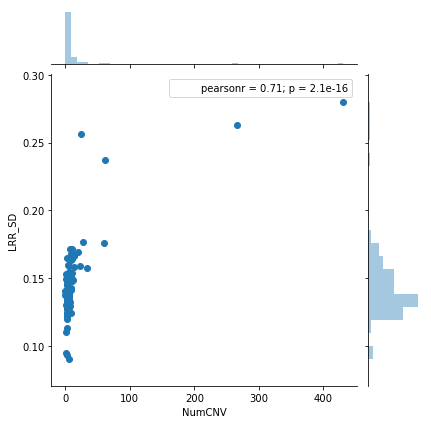

In [72]:
import pandas as pd

df = pd.read_table('/data/NCR_SBRB/simplex/penncnv/results/all_simplex_adjusted.qcsum')
# we ran for all samples, but let's look at only stats for samples in our simplex study
fid = open('/data/NCR_SBRB/simplex/sample_ids.txt', 'r')
samples = [line.rstrip() for line in fid]
fid.close()
keep_me = [i for i in range(df.shape[0]) if df.File[i].split('/')[-1] in samples]
df = df.iloc[keep_me]

%matplotlib inline

import seaborn as sns

sns.jointplot(x='NumCNV', y='LRR_SD', data=df)

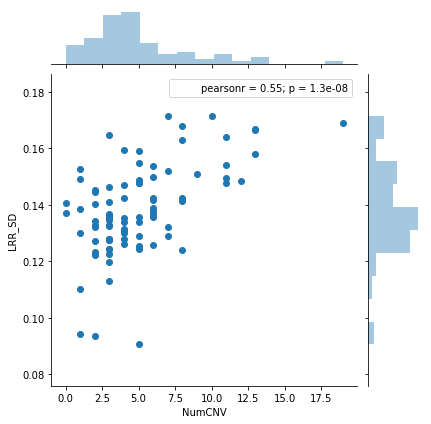

In [73]:
import numpy as np

sns.jointplot(x='NumCNV', y='LRR_SD', data=df[np.logical_and(df.NumCNV <= 20, df.LRR_SD<.2)])

In [74]:
df = df[np.logical_and(df.NumCNV <= 20, df.LRR_SD<.2)]
use_trio = []
samples_left = [fn.split('/')[-1] for fn in df.File]
for tn, trio in trios.iteritems():
    if (trio['child'] in samples_left and
        trio['mother'] in samples_left and
        trio['father'] in samples_left):
        use_trio.append(tn)
use_trio.sort()
use_trio

['10033_trio1',
 '10033_trio2',
 '10090_trio1',
 '10090_trio2',
 '10094_trio1',
 '10094_trio2',
 '10128_trio1',
 '10128_trio2',
 '10131_trio1',
 '10131_trio2',
 '10131_trio3',
 '10131_trio4',
 '10153_trio1',
 '10153_trio2',
 '10153_trio3',
 '10164_trio1',
 '10164_trio2',
 '10173_trio2',
 '10178_trio1',
 '10178_trio2',
 '10182_trio1',
 '10182_trio2',
 '10197_trio1',
 '10215_trio1',
 '10215_trio2',
 '10215_trio3',
 '10215_trio4',
 '10369_trio1',
 '10369_trio2',
 '10406_trio1',
 '10406_trio2',
 '10406_trio3',
 '10448_trio1',
 '10448_trio2',
 '10459_trio2',
 '1892_trio1',
 '1892_trio2',
 '1893_trio2',
 '1895_trio1',
 '1895_trio2',
 '1976_trio1',
 '1976_trio3',
 '855_trio1',
 '855_trio2']

In [76]:
import subprocess

cmd_str = "/usr/local/apps/penncnv/1.0.4/detect_cnv.pl -trio " \
          "-hmm ~/autodenovo/penncnv_example.hmm " \
          "-pfb InfiniumExome.pfb -cnv results/all_simplex_adjusted.rawcnv " \
          "InfiniumExome/%s InfiniumExome/%s InfiniumExome/%s " \
          "-out results/cleanNCNVse20LRRSDstp21_%s_adjusted.triocnv"
for trio in use_trio:
    print trio
    my_str = cmd_str % (trios[trio]['father'], trios[trio]['mother'],
                        trios[trio]['child'], trio)
    output = subprocess.check_output(my_str, shell=True,
                                     cwd='/data/NCR_SBRB/simplex/penncnv')

10033_trio1
10033_trio2
10090_trio1
10090_trio2
10094_trio1
10094_trio2
10128_trio1
10128_trio2
10131_trio1
10131_trio2
10131_trio3
10131_trio4
10153_trio1
10153_trio2
10153_trio3
10164_trio1
10164_trio2
10173_trio2
10178_trio1
10178_trio2
10182_trio1
10182_trio2
10197_trio1
10215_trio1
10215_trio2
10215_trio3
10215_trio4
10369_trio1
10369_trio2
10406_trio1
10406_trio2
10406_trio3
10448_trio1
10448_trio2
10459_trio2
1892_trio1
1892_trio2
1893_trio2
1895_trio1
1895_trio2
1976_trio1
1976_trio3
855_trio1
855_trio2


In [77]:
cmd_str = "/usr/local/apps/penncnv/1.0.4/detect_cnv.pl -trio " \
          "-hmm ~/autodenovo/penncnv_example.hmm " \
          "-pfb HumanExome.pfb -cnv results/all_simplex_adjusted.rawcnv " \
          "HumanExome/%s HumanExome/%s HumanExome/%s " \
          "-out results/cleanNCNVse20LRRSDstp21_%s_adjusted.triocnv"
for trio in ['10369_trio1', '10369_trio2']:
    print trio
    my_str = cmd_str % (trios[trio]['father'], trios[trio]['mother'],
                        trios[trio]['child'], trio)
    output = subprocess.check_output(my_str, shell=True,
                                     cwd='/data/NCR_SBRB/simplex/penncnv')

10369_trio1
10369_trio2


In [78]:
%%bash
cd /data/NCR_SBRB/simplex/penncnv/results

for triocnv in `ls -1 cleanNCNVse20LRRSDstp21_*_adjusted.triocnv`; do
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${triocnv}: `cat denovo.txt 2>/dev/null | wc -l` denovo, `cat inherited.txt 2>/dev/null | wc -l` inherited;
   rm *_snps;
done

cleanNCNVse20LRRSDstp21_10033_trio1_adjusted.triocnv: 0 denovo, 6 inherited
cleanNCNVse20LRRSDstp21_10033_trio2_adjusted.triocnv: 0 denovo, 5 inherited
cleanNCNVse20LRRSDstp21_10090_trio1_adjusted.triocnv: 0 denovo, 3 inherited
cleanNCNVse20LRRSDstp21_10090_trio2_adjusted.triocnv: 0 denovo, 10 inherited
cleanNCNVse20LRRSDstp21_10094_trio1_adjusted.triocnv: 0 denovo, 11 inherited
cleanNCNVse20LRRSDstp21_10094_trio2_adjusted.triocnv: 0 denovo, 7 inherited
cleanNCNVse20LRRSDstp21_10128_trio1_adjusted.triocnv: 0 denovo, 4 inherited
cleanNCNVse20LRRSDstp21_10128_trio2_adjusted.triocnv: 0 denovo, 6 inherited
cleanNCNVse20LRRSDstp21_10131_trio1_adjusted.triocnv: 0 denovo, 12 inherited
cleanNCNVse20LRRSDstp21_10131_trio2_adjusted.triocnv: 1 denovo, 8 inherited
cleanNCNVse20LRRSDstp21_10131_trio3_adjusted.triocnv: 0 denovo, 16 inherited
cleanNCNVse20LRRSDstp21_10131_trio4_adjusted.triocnv: 0 denovo, 21 inherited
cleanNCNVse20LRRSDstp21_10153_trio1_adjusted.triocnv: 1 denovo, 5 inherited
cleanNC

The numbers change, but still not much difference between the groups.

# Non-autossomal CNVs

Maybe there is something in the non-autossomal chromossomes (ran outside)?

In [ ]:
%%bash
module load penncnv

cd /data/NCR_SBRB/simplex/penncnv

pfb_file=InfiniumExome.pfb
detect_cnv.pl --chrx -test -hmm ~/autodenovo/penncnv_example.hmm \
    -pfb $pfb_file -log results/Xall_simplex_but1.log InfiniumExome/* \
    -out results/Xall_simplex_but1.rawcnv;

pfb_file=HumanExome.pfb
detect_cnv.pl --chrx -test -hmm ~/autodenovo/penncnv_example.hmm \
    -pfb $pfb_file -log results/Xfam_10369.log HumanExome/* \
    -out results/Xfam_10369.rawcnv;

In [38]:
%%bash
module load penncnv

cd /data/NCR_SBRB/simplex/penncnv/results
cat Xall_simplex_but1.log Xfam_10369.log > Xall_simplex.log
cat Xall_simplex_but1.rawcnv Xfam_10369.rawcnv > Xall_simplex.rawcnv
filter_cnv.pl Xall_simplex.rawcnv -qclogfile Xall_simplex.log \
    -qcpassout Xall_simplex.qcpass --chrx \
    -qcsumout Xall_simplex.qcsum -out Xall_simplex

NOTICE: the --qclrrsd argument is set as 0.3 by default
NOTICE: the --qcbafdrift argument is set as 0.01 by default
NOTICE: the --qcwf argument is set as 0.05 by default
NOTICE: Writting 127 file names that pass QC to qcpass file Xall_simplex.qcpass
NOTICE: Writting 130 records of QC summary to qcsum file Xall_simplex.qcsum


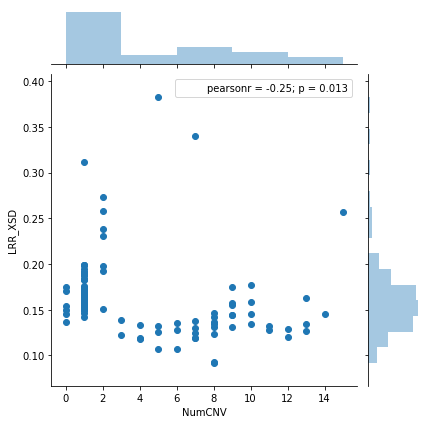

In [79]:
import pandas as pd

df = pd.read_table('/data/NCR_SBRB/simplex/penncnv/results/Xall_simplex.qcsum')
# we ran for all samples, but let's look at only stats for samples in our simplex study
fid = open('/data/NCR_SBRB/simplex/sample_ids.txt', 'r')
samples = [line.rstrip() for line in fid]
fid.close()
keep_me = [i for i in range(df.shape[0]) if df.File[i].split('/')[-1] in samples]
df = df.iloc[keep_me]

%matplotlib inline

import seaborn as sns

sns.jointplot(x='NumCNV', y='LRR_XSD', data=df)

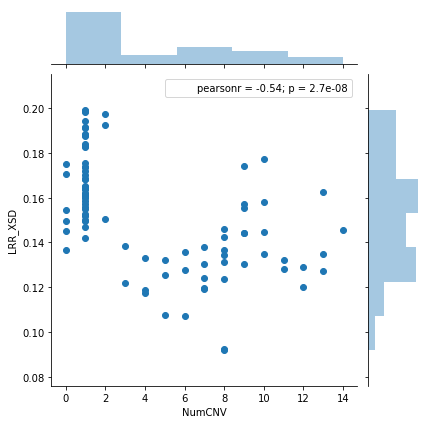

In [80]:
sns.jointplot(x='NumCNV', y='LRR_XSD', data=df[df.LRR_XSD<.21])

In [81]:
df = df[df.LRR_XSD<.21]
use_trio = []
samples_left = [fn.split('/')[-1] for fn in df.File]
for tn, trio in trios.iteritems():
    if (trio['child'] in samples_left and
        trio['mother'] in samples_left and
        trio['father'] in samples_left):
        use_trio.append(tn)
use_trio.sort()
use_trio

['10033_trio1',
 '10033_trio2',
 '10090_trio1',
 '10090_trio2',
 '10094_trio1',
 '10094_trio2',
 '10128_trio1',
 '10128_trio2',
 '10131_trio1',
 '10131_trio2',
 '10131_trio3',
 '10131_trio4',
 '10153_trio1',
 '10153_trio2',
 '10153_trio3',
 '10164_trio1',
 '10164_trio2',
 '10173_trio2',
 '10178_trio1',
 '10178_trio2',
 '10182_trio1',
 '10182_trio2',
 '10182_trio3',
 '10197_trio1',
 '10197_trio2',
 '10215_trio2',
 '10215_trio3',
 '10215_trio4',
 '10369_trio1',
 '10369_trio2',
 '10406_trio1',
 '10406_trio2',
 '10406_trio3',
 '10448_trio1',
 '10448_trio2',
 '10459_trio2',
 '1892_trio1',
 '1892_trio2',
 '1895_trio2',
 '1976_trio1',
 '1976_trio3',
 '855_trio1',
 '855_trio2']

In [82]:
import subprocess

cmd_str = "/usr/local/apps/penncnv/1.0.4/detect_cnv.pl -trio --chrx " \
          "-hmm ~/autodenovo/penncnv_example.hmm " \
          "-pfb InfiniumExome.pfb -cnv results/Xall_simplex.rawcnv " \
          "InfiniumExome/%s InfiniumExome/%s InfiniumExome/%s " \
          "-out results/cleanLRRXSDstp21_%s_chrX.triocnv"
for trio in use_trio:
    print trio
    my_str = cmd_str % (trios[trio]['father'], trios[trio]['mother'],
                        trios[trio]['child'], trio)
    output = subprocess.check_output(my_str, shell=True,
                                     cwd='/data/NCR_SBRB/simplex/penncnv')

cmd_str = "/usr/local/apps/penncnv/1.0.4/detect_cnv.pl -trio --chrx " \
          "-hmm ~/autodenovo/penncnv_example.hmm " \
          "-pfb HumanExome.pfb -cnv results/all_simplex_adjusted.rawcnv " \
          "HumanExome/%s HumanExome/%s HumanExome/%s " \
          "-out results/cleanLRRXSDstp21_%s_chrX.triocnv"
for trio in ['10369_trio1', '10369_trio2']:
    print trio
    my_str = cmd_str % (trios[trio]['father'], trios[trio]['mother'],
                        trios[trio]['child'], trio)
    output = subprocess.check_output(my_str, shell=True,
                                     cwd='/data/NCR_SBRB/simplex/penncnv')

10033_trio1
10033_trio2
10090_trio1
10090_trio2
10094_trio1
10094_trio2
10128_trio1
10128_trio2
10131_trio1
10131_trio2
10131_trio3
10131_trio4
10153_trio1
10153_trio2
10153_trio3
10164_trio1
10164_trio2
10173_trio2
10178_trio1
10178_trio2
10182_trio1
10182_trio2
10182_trio3
10197_trio1
10197_trio2
10215_trio2
10215_trio3
10215_trio4
10369_trio1
10369_trio2
10406_trio1
10406_trio2
10406_trio3
10448_trio1
10448_trio2
10459_trio2
1892_trio1
1892_trio2
1895_trio2
1976_trio1
1976_trio3
855_trio1
855_trio2
10369_trio1
10369_trio2


In [83]:
%%bash
cd /data/NCR_SBRB/simplex/penncnv/results

for triocnv in `ls -1 cleanLRRXSDstp21_*_chrX.triocnv`; do
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${triocnv}: `cat denovo.txt 2>/dev/null | wc -l` denovo, `cat inherited.txt 2>/dev/null | wc -l` inherited;
   rm *_snps;
done

cleanLRRXSDstp21_10033_trio1_chrX.triocnv: 1 denovo, 2 inherited
cleanLRRXSDstp21_10033_trio2_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10090_trio1_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10090_trio2_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10094_trio1_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10094_trio2_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10128_trio1_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10128_trio2_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10131_trio1_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10131_trio2_chrX.triocnv: 3 denovo, 0 inherited
cleanLRRXSDstp21_10131_trio3_chrX.triocnv: 1 denovo, 1 inherited
cleanLRRXSDstp21_10131_trio4_chrX.triocnv: 0 denovo, 1 inherited
cleanLRRXSDstp21_10153_trio1_chrX.triocnv: 0 denovo, 2 inherited
cleanLRRXSDstp21_10153_trio2_chrX.triocnv: 0 denovo, 0 inherited
cleanLRRXSDstp21_10153_trio3_chrX.triocnv: 0 denovo, 2 inherited
cleanLRRXSDstp21_10164_tr

Same story... no specific pattern I can eyeball.

# TODO

* play with HMM parameters
* compare to multiplex families? (only using trios with NV parents? use only affected kids from both cohorts? need to use WPS samples too!)